<a href="https://colab.research.google.com/github/Beenaa99/Strawberry_Leaf_Disease_Detection/blob/main/resnet34_strawberry_leaf_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ResNet34 model used for multi class classification of diseases (bacteria/fungi) in strawberry leaves. Dataset has already been normalized and split into train test (80-20-20)(https://github.com/Beenaa99/Strawberry_Leaf_Disease_Detection/blob/main/Data_splitting_strawberry_leaves.ipynb)

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from google.colab import drive
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report

drive.mount('/content/drive')

# Define paths
train_dir = '/content/drive/MyDrive/omdena/Image Collection/Strawberry Leaf - Beenaa/Split_data/train'
val_dir = '/content/drive/MyDrive/omdena/Image Collection/Strawberry Leaf - Beenaa/Split_data/val'
test_dir = '/content/drive/MyDrive/omdena/Image Collection/Strawberry Leaf - Beenaa/Split_data/test'

# Define transformations (only resizing)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Define data loaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Class names
class_names = train_dataset.classes


Mounted at /content/drive


Loading pre-trained ResNet34 model for tranfer learning

In [ ]:
# Loading pre-trained ResNet34 model
resnet34 = models.resnet34(pretrained=True)

# Freezing base model layer
for param in resnet34.parameters():
    param.requires_grad = False

# Modifying final layers to fit our class_names length
num_ftrs = resnet34.fc.in_features
resnet34.fc = nn.Sequential(
    nn.Linear(num_ftrs, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, len(class_names))
)

# GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet34 = resnet34.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 194MB/s]


Training, Validation and Evaluation Function

In [ ]:

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet34.fc.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct.double() / total
        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
        validate_model(model, val_loader, criterion)

# Validation function
def validate_model(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)
        val_loss = running_loss / len(val_loader.dataset)
        val_acc = correct.double() / total
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    return cm, cr


In [ ]:
train_model(resnet34, train_loader, val_loader, criterion, optimizer, num_epochs=25)

Epoch 0/24, Loss: 0.3830, Accuracy: 0.8691
Validation Loss: 0.0866, Validation Accuracy: 0.9839
Epoch 1/24, Loss: 0.0508, Accuracy: 0.9889
Validation Loss: 0.0306, Validation Accuracy: 0.9935
Epoch 2/24, Loss: 0.0246, Accuracy: 0.9957
Validation Loss: 0.0222, Validation Accuracy: 0.9946
Epoch 3/24, Loss: 0.0167, Accuracy: 0.9971
Validation Loss: 0.0182, Validation Accuracy: 0.9946
Epoch 4/24, Loss: 0.0089, Accuracy: 0.9982
Validation Loss: 0.0145, Validation Accuracy: 0.9968
Epoch 5/24, Loss: 0.0077, Accuracy: 0.9982
Validation Loss: 0.0119, Validation Accuracy: 0.9957
Epoch 6/24, Loss: 0.0040, Accuracy: 1.0000
Validation Loss: 0.0104, Validation Accuracy: 0.9978
Epoch 7/24, Loss: 0.0034, Accuracy: 1.0000
Validation Loss: 0.0106, Validation Accuracy: 0.9968
Epoch 8/24, Loss: 0.0022, Accuracy: 1.0000
Validation Loss: 0.0083, Validation Accuracy: 0.9978
Epoch 9/24, Loss: 0.0017, Accuracy: 1.0000
Validation Loss: 0.0097, Validation Accuracy: 0.9968
Epoch 10/24, Loss: 0.0014, Accuracy: 1.0

In [ ]:
# Saving model
model_path = "resnet34_model.pth"
torch.save(resnet34.state_dict(), model_path)

print(f"Model saved to {model_path}")

Model saved to resnet34_model.pth


In [ ]:
cm, cr = evaluate_model(resnet34, test_loader)

In [ ]:
cr

{'angular_leaf_spots_bacteria': {'precision': 0.9767441860465116,
  'recall': 0.9655172413793104,
  'f1-score': 0.9710982658959537,
  'support': 87},
 'healthy_leaf': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 365},
 'leaf_scorch_fungus': {'precision': 0.9971751412429378,
  'recall': 0.9943661971830986,
  'f1-score': 0.995768688293371,
  'support': 355},
 'leaf_spot_fungus': {'precision': 0.976,
  'recall': 0.991869918699187,
  'f1-score': 0.9838709677419355,
  'support': 123},
 'accuracy': 0.9935483870967742,
 'macro avg': {'precision': 0.9874798318223623,
  'recall': 0.987938339315399,
  'f1-score': 0.987684480482815,
  'support': 930},
 'weighted avg': {'precision': 0.9935719562659026,
  'recall': 0.9935483870967742,
  'f1-score': 0.9935479166767234,
  'support': 930}}

Classification Report:
Precision: 0.99
Recall: 0.99
F1 Score: 0.99


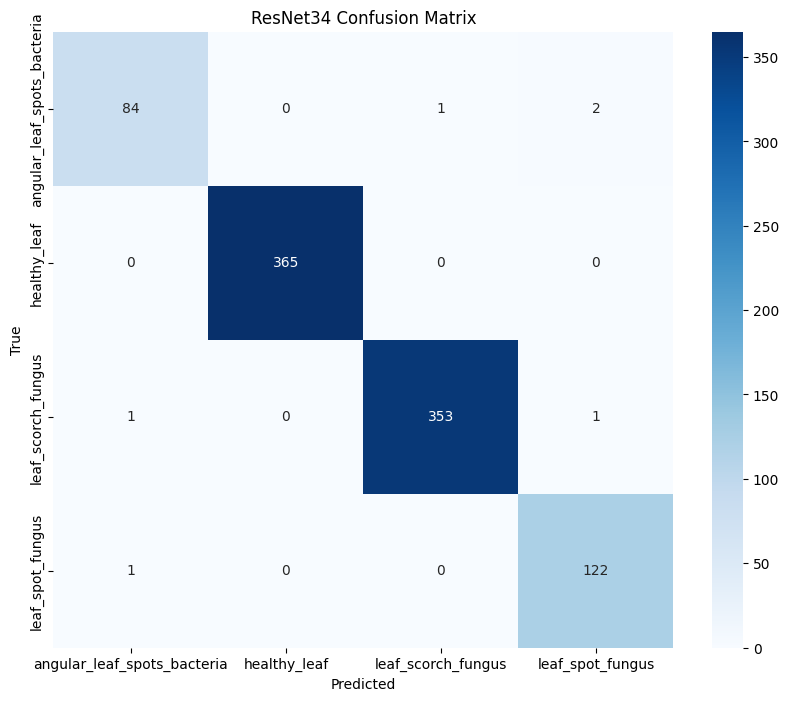

In [ ]:
#classification report
print("Classification Report:")
print(f"Precision: {cr['macro avg']['precision']:.2f}")
print(f"Recall: {cr['macro avg']['recall']:.2f}")
print(f"F1 Score: {cr['macro avg']['f1-score']:.2f}")

#confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

plot_confusion_matrix(cm, class_names, title="ResNet34 Confusion Matrix")


Classification report per class

In [ ]:
def print_classification_report(report):
    print("Classification Report:")
    for class_name, metrics in report.items():
        if isinstance(metrics, dict):
            print(f"Class: {class_name}")
            print(f"  Precision: {metrics['precision']:.2f}")
            print(f"  Recall: {metrics['recall']:.2f}")
            print(f"  F1 Score: {metrics['f1-score']:.2f}")
            print(f"  Support: {metrics['support']}")

In [ ]:
print_classification_report(cr)

Classification Report:
Class: angular_leaf_spots_bacteria
  Precision: 0.98
  Recall: 0.97
  F1 Score: 0.97
  Support: 87
Class: healthy_leaf
  Precision: 1.00
  Recall: 1.00
  F1 Score: 1.00
  Support: 365
Class: leaf_scorch_fungus
  Precision: 1.00
  Recall: 0.99
  F1 Score: 1.00
  Support: 355
Class: leaf_spot_fungus
  Precision: 0.98
  Recall: 0.99
  F1 Score: 0.98
  Support: 123
Class: macro avg
  Precision: 0.99
  Recall: 0.99
  F1 Score: 0.99
  Support: 930
Class: weighted avg
  Precision: 0.99
  Recall: 0.99
  F1 Score: 0.99
  Support: 930
